In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
import numpy as np
from PIL import Image 
from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt 

# Loading Data
## Dimensiom of data is 400 * 10304

In [4]:
D = np.zeros((400,10304))
datasetPath = "/content/drive/My Drive/dataset/"
   
for subject in range(40):
    subjectPath = datasetPath + "s" + str(subject + 1)
    for image in range(10):
        filePath = subjectPath +"/" + str(image + 1) + ".pgm"
        im = Image.open(filePath)
        D[subject * 10 + image,:] = np.asarray(im).T.flatten()


# Generate the label vector y

In [6]:
y = np.zeros((400,))
for i in range(40):
    for j in range (10):
        y[i * 10 + j] = i + 1;

#Spliting data to training and testing samples

In [7]:
trainingData = D[::2]
testingData = D[1::2]

yTraining = y[::2]
yTesting = y[1::2]

# change the dimentions into d*n where d (10304) is the number of featires and 
# n(200) is the number of samples in each
trainingData = trainingData.T
testingData = testingData.T
n = 200
d = 10304

# PCA algorithm

In [8]:

#compute mean
mean = np.mean(trainingData, axis=1).reshape((d, 1))

# center the data
Z = trainingData - mean @ np.ones((1, n))

# compute covariance matrix  
covMat = (Z @ Z.T) / n  

##comupting eigenvalues and eigenvectors of the covariance matrix


In [9]:
eigenVal, eigenVec = np.linalg.eigh(covMat)
# sorting eigenVal and eigenVec
indices = eigenVal.argsort()[::-1]
eigenVal = eigenVal[indices]
eigenVec = eigenVec[:,indices]

## helper function to find projection matrix according to alpha

In [10]:
def projectionMatrix(eigenVal, eigenVec, alpha):
    req = 0
    numberOfAxis = 0
    eigenValSum = np.sum(eigenVal)
    for i in range(eigenVal.size):
        numberOfAxis = i ;
        req = req + eigenVal[i]
        ratio = req / eigenValSum
        if(ratio >= alpha):
            break
    U = eigenVec[:,:numberOfAxis + 1]
    return U

[[0.95  0.865 0.895 0.86  0.85  0.825 0.805 0.78  0.78  0.77 ]
 [0.95  0.87  0.895 0.87  0.845 0.79  0.775 0.765 0.755 0.755]
 [0.94  0.85  0.89  0.865 0.835 0.78  0.77  0.745 0.75  0.7  ]
 [0.94  0.845 0.895 0.87  0.845 0.775 0.74  0.74  0.735 0.695]]


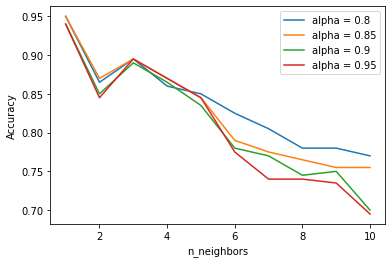

In [11]:
alphas = np.array([0.8,0.85,0.9,0.95])
comparision = np.empty((4, 10))
for alpha in range (alphas.size):
  U = projectionMatrix(eigenVal, eigenVec, alphas[alpha])
  projTrainData = U.T @ trainingData;
  projTestData = U.T @ testingData;

  neighbors = np.arange(1, 11) 
  test_accuracy = np.empty(len(neighbors)) 
  for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(projTrainData.T,yTraining ) 

    # Compute test data accuracy 
    test_accuracy[i] = knn.score(projTestData.T, yTesting)
  plt.plot(neighbors, test_accuracy, label = 'alpha = ' + str(alphas[alpha])) 
  comparision[alpha] = test_accuracy
print(comparision)
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

# LDA algorithm

In [12]:
#number of samples per class
nk = 5

#number of classes
NoOfClasses = 40

#overall mean
overallMean = np.mean(trainingData, axis=1).reshape((d, 1))

#the between-class scatter matrix
Sb = np.zeros((d, d))

#the within-class scatter matrix
S = np.zeros((d, d))

for i in range(NoOfClasses):
  #computing mean of each class i
  muek = np.mean(trainingData[:, nk*i : nk*(i+1)], axis=1).reshape((d, 1))

  #computing the between-class scatter matrix
  meanDiff = muek - overallMean
  Sb = Sb + (meanDiff @ meanDiff.T) * nk
  
  #computing the within-class scatter matrix
  Zi = trainingData[:, nk*i : nk*(i+1)] - muek @ np.ones((1, 5))
  Si = Zi @ Zi.T
  S = S + Si

print(Sb.shape, S.shape)


(10304, 10304) (10304, 10304)


In [13]:
Sinv = np.linalg.inv(S)
SinvSb = Sinv @ Sb

#compute eigenvalues and eigenvectors
eigenVal2, eigenVec2 = np.linalg.eigh(SinvSb)
# sorting eigenVal and eigenVec
indices = eigenVal2.argsort()[::-1]
#eigenVal2 = eigenVal2[indices]
eigenVec2 = eigenVec2[:,indices]

# projection matrix using the 39 dominant eigenvectors
U = eigenVec2[:,0: 39]

[0.965 0.885 0.895 0.87  0.805 0.76  0.76  0.715 0.68  0.675]


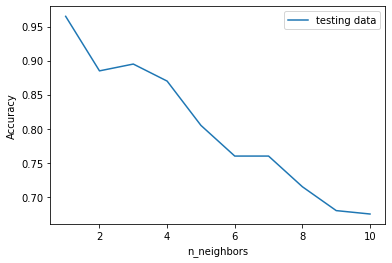

In [14]:
projTrainData = U.T @ trainingData;
projTestData = U.T @ testingData;
neighbors = np.arange(1, 11) 
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(projTrainData.T,yTraining ) 
    # Compute test data accuracy 
    test_accuracy[i] = knn.score(projTestData.T, yTesting)
print(test_accuracy)
plt.plot(neighbors, test_accuracy, label = 'testing data')
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 